For any combination of Hamiltonin, ansatz, and error model, we can plot the following:

1. Ditribution of $\epsilon_{jk}$
2. Error response for a bunch of permutations (depends on the seed of permutations)
3. Extrapolation mean and uncertainty as a function of the sample size

To illustrate our point, we need two Hamiltonians: one with a "nice" distribution of $\epsilon_{jk}$, another with a "naughty" one. We expect the latter to have a worse adherence to the linear trend. 

In [1]:
from vqe_vs_sum import *
from copy import copy, deepcopy
from qiskit.algorithms.optimizers import L_BFGS_B
from enum import Enum, auto
from scipy.optimize import minimize
from qiskit_aer.backends import QasmSimulator, AerSimulator
from qiskit import execute
from math import factorial
from scipy.stats import linregress
from pathlib import Path
import time
import json


plt.rcParams.update({"font.size": 14})

In [2]:
class HamiltonianType(Enum):
    ISING = auto()
    LOCALLY_TILTED_ISING = auto()
    

class AnsatzType(Enum):
    CIRCULAR = auto()
    LINEAR = auto()
    
    
class NoiseType(Enum):
    DEPOL = auto()
    BITFLIP = auto()
    PHASEFLIP = auto()
    MS = auto()
    DEPOL_2 = auto()
    

class StartingPoint(Enum):
    ZERO = auto()
    SMALL_RANDOM = auto()
    BIG_RANDOM = auto()

In [3]:
def get_hamiltonian(hamiltonian_type: HamiltonianType, n_qubits: int, **kwargs):
    if hamiltonian_type == HamiltonianType.ISING:
        h = ising_model(n_qubits, 1, 1)
    elif hamiltonian_type == HamiltonianType.LOCALLY_TILTED_ISING:
        h = ising_model(n_qubits, 1, 1)
        h += dictionary_to_pauliop({"ZZ" + "I" * (n_qubits - 2): 5})
    else:
        raise ValueError("No such hamiltonian")
    return h

In [4]:
get_hamiltonian(HamiltonianType.LOCALLY_TILTED_ISING, 4)

PauliSumOp(SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 5.+0.j]), coeff=1.0)

### Set up the inputs

If you want this to work well, launch all cells starting from here. That way all RNG outputs should be traceable back to one seed.

In [5]:
h_type = HamiltonianType.ISING
ansatz_type = AnsatzType.CIRCULAR
noise_type = NoiseType.DEPOL
vqe_starting_point = StartingPoint.SMALL_RANDOM

save = True

n_qubits = 10
# n_perms_for_example = factorial(n_qubits)
n_perms_for_example = 100
perms_numbers = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# perms_numbers = [10, 11]
tests_per_perm_qty = 50

ansatz_depth = 5

global_seed = 0
noise_seed = 0

input_dict = {"h_type": h_type.name, 
              "ansatz_type":  ansatz_type.name,
              "noise_type": noise_type.name,
              "vqe_starting_point": vqe_starting_point.name,
              "n_qubits": n_qubits,
              "n_perms_for_example": n_perms_for_example,
              "perms_numbers": perms_numbers,
              "tests_per_perm_qty": tests_per_perm_qty,
              "ansatz_depth": ansatz_depth,
              "global_seed": 0,
              "noise_seed": 0,
              "note": "All experiments before Mar 28 have a different qs sampling procedure"}
print(input_dict)

{'h_type': 'ISING', 'ansatz_type': 'CIRCULAR', 'noise_type': 'DEPOL', 'vqe_starting_point': 'SMALL_RANDOM', 'n_qubits': 10, 'n_perms_for_example': 100, 'perms_numbers': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'tests_per_perm_qty': 50, 'ansatz_depth': 5, 'global_seed': 0, 'noise_seed': 0, 'note': 'All experiments before Mar 28 have a different qs sampling procedure'}


In [6]:
if save:
    expt_id = time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime())
    foldername = "./" + str(expt_id)
    Path(foldername).mkdir(parents=True, exist_ok=True)
    with open("./" + str(expt_id) + "/inputs.txt", "w") as fp:
        json.dump(input_dict, fp)

### Get a VQE solution for the noiseless case

Careful with the number of iterations, default is 100, but for debugging I may have put something like 3

In [7]:
%%time
rng = np.random.default_rng(global_seed)

circ = TwoLocal(n_qubits, ['ry'], 'rxx',
                entanglement=ansatz_type.name.lower(),
                reps=ansatz_depth)
circ = unpack_twolocal(circ)

h = get_hamiltonian(h_type, n_qubits)


def get_energy_estimator(ansatz: QuantumCircuit, h: PauliSumOp, noise_model: NoiseModel):
    """Energy estimator function that treats the noisy state as a density matrix and
    performs all calculations exactly. Use when you don't want the optimization process
    to be realistic, but are interested in the optimization landscape itself."""
    def f(x):
        noisy_backend = AerSimulator(method='density_matrix',
                                      noise_model=noise_model)
        ansatz_2 = ansatz.copy()
        ansatz_2.save_density_matrix()
        ansatz_2 = ansatz_2.bind_parameters(x)
        result = execute(ansatz_2, noisy_backend).result()
        dm = result.data()['density_matrix']
        return np.trace(dm.data @ h.to_matrix()).real
    return f


if vqe_starting_point == StartingPoint.ZERO:
    x_0 = np.zeros(circ.num_parameters)
elif vqe_starting_point == StartingPoint.SMALL_RANDOM:
    x_0 = rng.normal(scale=1e-3, size=(circ.num_parameters))   
elif vqe_starting_point == StartingPoint.BIG_RANDOM:
    x_0 = rng.uniform(high=2 * np.pi, size=(circ.num_parameters))
    
foo_clean = get_energy_estimator(circ, h, None)

sol_clean = minimize(foo_clean, x_0, 
                     tol=1e-5, options={'maxiter': 100})

print(sol_clean.fun, sol_clean.message, "\n", sol_clean.x)

-12.681994553042976 Maximum number of iterations has been exceeded. 
 [-0.27553241 -0.10643576 -0.26778199 -0.32310524 -0.47122622 -0.41506983
 -0.23418932 -0.26751876 -0.23286169 -0.4338105  -0.30936731  0.3113713
 -0.37579393  0.40221596 -0.27689545  0.28597163 -0.36661466  0.24066386
 -0.2502858   0.37258165 -0.35638017 -0.32619737 -0.48818237 -0.37170919
 -0.51607487 -0.30826545 -0.30327649 -0.43498651 -0.35773837 -0.4490856
  0.22205149 -0.25854703  0.25031066 -0.26408632  0.16553852 -0.14757745
  0.10900783 -0.00814706  0.0224408  -0.23364828 -0.47440473 -0.36511644
 -0.5539066  -0.20720121 -0.50691397 -0.23315323 -0.41708107 -0.41201421
 -0.49389388 -0.29544016 -0.0578267   0.12090186 -0.02280654 -0.05470554
 -0.13049399  0.09959793  0.22518321 -0.23207554  0.27210964 -0.16328225
 -0.39565713 -0.36703664 -0.43987994 -0.39305523 -0.25821142 -0.33774608
 -0.53721539 -0.29807524 -0.51559237 -0.12789238 -0.47318197  0.4169763
 -0.42106133  0.48020177 -0.67209033  0.58874708 -0.37387

In [8]:
list(sol_clean.keys())

['fun',
 'jac',
 'hess_inv',
 'nfev',
 'njev',
 'status',
 'success',
 'message',
 'x',
 'nit']

In [9]:
sol_jsonisable = {}
for k, v in sol_clean.items():
    if k == 'hess_inv':
        continue
    if type(v) == np.ndarray or type(v) == np.array:
        sol_jsonisable[k] = list(v)
    else:
        sol_jsonisable[k] = v


print(sol_jsonisable)

{'fun': -12.681994553042976, 'jac': [0.004435062408447266, 0.00011527538299560547, 0.0015332698822021484, 0.0010197162628173828, -0.0007218122482299805, -0.0012325048446655273, 0.0035123825073242188, -0.0036984682083129883, 0.003863811492919922, 0.00022554397583007812, -0.00203704833984375, -0.0025768280029296875, 0.0020819902420043945, 0.0026389360427856445, 0.002473115921020508, 0.001855611801147461, 0.0029660463333129883, -0.0018137693405151367, 0.002587437629699707, 0.0027745962142944336, 0.002433180809020996, -0.00025212764739990234, 0.0012432336807250977, -0.0013988018035888672, -0.0005730390548706055, -0.0003943443298339844, 0.00026702880859375, -0.0005897283554077148, 0.00340116024017334, -0.0005577802658081055, -0.0020422935485839844, -0.002164125442504883, -0.00021648406982421875, 0.0009933710098266602, 0.004495859146118164, 0.0026063919067382812, 0.005473613739013672, -0.0011082887649536133, 0.0029289722442626953, -0.001783609390258789, 0.004283785820007324, -0.0003021955490

In [10]:
with open(foldername + "/sol.txt", "w") as fp:
    json.dump(sol_jsonisable, fp)

### Show the distribution of $\epsilon_{jk}$

In [11]:
sv_backend = Aer.get_backend("statevector_simulator")
from qiskit import execute


def e_gs(circ, params, noise_type):
    """Return E_g for every gate g"""
    circ_bnd = circ.bind_parameters(params)
    names = [gate_name(gate) for gate in circ_bnd.data]
    indices = [i for i, x in enumerate(names) if x == "rxx"]
    qty_circs = 16 * len(indices)
    
    new_circs = get_intermediate_circuits(circ_bnd, 
                                          noise_type, 
                                          indices)
    
    if noise_type != NoiseType.MS:
    
        state_original = get_state(circ_bnd)
        states_with_errors = [get_state(c) for c in new_circs]
        Es_k = [state.expectation_value(h).real 
                for state in states_with_errors]
        batchmeans = [np.mean(Es_k[16 * i : 16 * (i + 1)]) 
                      for i in range(len(indices))]

        return batchmeans
    
    else:
        
        state_original = get_state(circ_bnd)
        states_with_errors = [get_state(c) for c in new_circs]
        Es_k = [state.expectation_value(h).real 
                for state in states_with_errors]
        # batchmeans = [np.mean(Es_k[16 * i : 16 * (i + 1)]) 
        #               for i in range(len(indices))]

        return Es_k
    
    
def get_state(circ):
    """Takes a circuit and returns a pure statevector"""
    job = execute(circ, sv_backend)
    result = job.result()
    state = result.get_statevector(circ)
    return state

    
def get_intermediate_circuits(circ_in, noisetype, indices):
    """Returns a list of circuits that appear when noise affects the gates"""
    new_circs = []

    if noisetype != NoiseType.MS:

        for i, index in enumerate(indices):
            for j in range(16):
                new_circ = deepcopy(circ_in)
                if noisetype == NoiseType.BITFLIP:
                    gates = [new_circ.id, new_circ.id, new_circ.x, new_circ.x]
                elif noisetype == NoiseType.PHASEFLIP:
                    gates = [new_circ.id, new_circ.id, new_circ.z, new_circ.z]
                elif noisetype == NoiseType.DEPOL:
                    gates = [new_circ.id, new_circ.x, new_circ.y, new_circ.z]
                rxx_qubits = [qbt.index for qbt in new_circ.data[index].qubits]
                gates[j % 4](rxx_qubits[0])
                gates[j // 4](rxx_qubits[1])
                new_circ.data.insert(index + 1, new_circ.data[-1])
                new_circ.data.insert(index + 1, new_circ.data[-2])
                new_circ.data.pop(-1)
                new_circ.data.pop(-1)
                new_circs.append(new_circ)

    else:
        for i, index in enumerate(indices):
            new_circ = deepcopy(circ_in)
            rxx_qubits = [qbt.index for qbt in new_circ.data[index].qubits]
            new_circ.x(rxx_qubits[0])
            new_circ.x(rxx_qubits[1])
            new_circ.data.insert(index + 1, new_circ.data[-1])
            new_circ.data.insert(index + 1, new_circ.data[-2])
            new_circ.data.pop(-1)
            new_circ.data.pop(-1)
            new_circs.append(new_circ)
    
    return new_circs


def gate_name(gate):
    return gate.operation.name

In [12]:
perturbed_energies = e_gs(circ, sol_clean.x, noise_type)
print(perturbed_energies)

[-9.604872874033003, -9.47353208042973, -9.449063918344443, -9.334282746967443, -9.492522423584596, -9.434641136083403, -9.503277985896567, -9.437979534471639, -9.565160210614156, -9.398612032431926, -9.37960542437431, -9.429946523503421, -9.266356371757817, -9.485500585548428, -9.40121648576228, -9.45815175882094, -9.40921894552445, -9.464882288940657, -9.372886237169553, -9.371130284235587, -9.556350965351726, -9.489764963476178, -9.436113093139072, -9.473731439429994, -9.473525203623982, -9.444319837111948, -9.418824494168554, -9.547490839706395, -9.431027560433055, -9.458805813953065, -9.476898857687985, -9.45636983177067, -9.48383241073585, -9.458801732113795, -9.445917297304163, -9.422899867760094, -9.474710588761358, -9.450940542549647, -9.517139665004832, -9.47446023819389, -9.453060063209826, -9.455626594876312, -9.458040383659425, -9.452719086324116, -9.452023522367341, -9.452114002727559, -9.460003482124863, -9.452114775595152, -9.475272326398706, -9.451415135897314]


In [13]:
epsilons = perturbed_energies - np.mean(perturbed_energies)

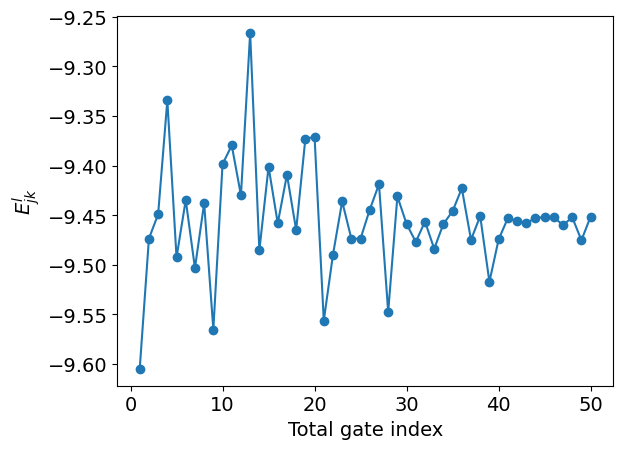

In [14]:
plt.plot(np.arange(len(perturbed_energies)) + 1, 
         perturbed_energies, 'o-')
plt.xlabel("Total gate index")
plt.ylabel("$E_{jk}^l$")
plt.show()

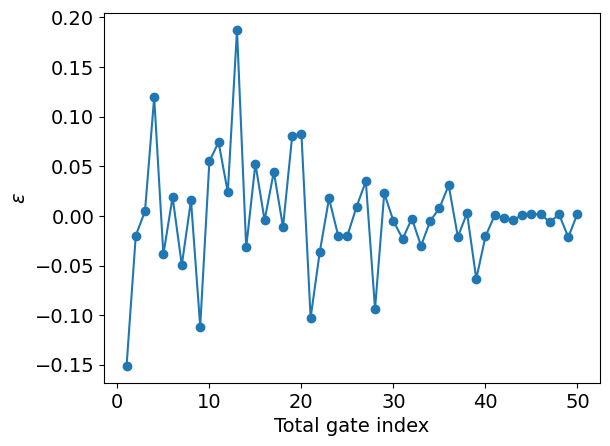

In [15]:
plt.plot(np.arange(len(perturbed_energies)) + 1, 
         epsilons, 'o-')
plt.xlabel("Total gate index")
plt.ylabel("$\epsilon$")
if save:
    plt.savefig(foldername + "/epsilons.png", dpi=400, bbox_inches='tight')
    np.savetxt(foldername + '/epsilons.txt', epsilons)

In [16]:
gates_per_layer = len(perturbed_energies) // ansatz_depth
aggregated_epsilons = np.zeros(gates_per_layer)
for i in range(ansatz_depth):
    aggregated_epsilons += epsilons[i * gates_per_layer: (i+1) * gates_per_layer]
    aggregated_epsilons = aggregated_epsilons

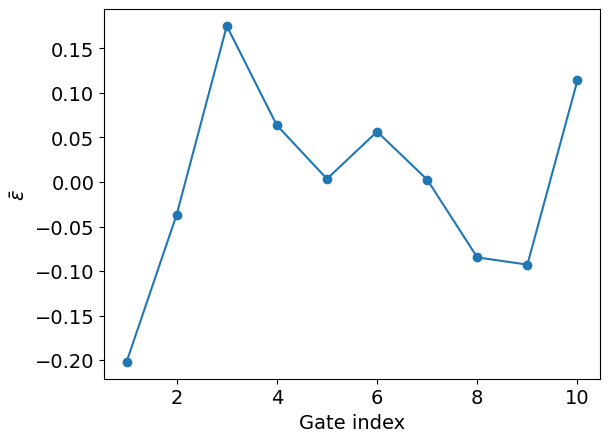

In [17]:
plt.plot(np.arange(gates_per_layer) + 1, 
         aggregated_epsilons, 'o-')
plt.xlabel("Gate index")
plt.ylabel("$\\bar{\epsilon}$")
if save:
    plt.savefig(foldername + "/aggregated_epsilons.png", dpi=400, bbox_inches='tight')
    np.savetxt(foldername + '/aggregated_epsilons.txt', aggregated_epsilons)


### Sample a number of permutations and show a fit

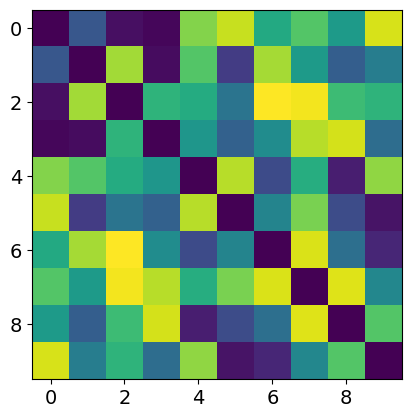

In [18]:
noise_rng = np.random.default_rng(noise_seed)

qs = noise_rng.uniform(high=1e-2, size=(n_qubits, n_qubits))
# qs = (qs + qs.T) / 2
# qs = qs - np.diag(np.diag(qs))
qs = np.triu(qs, 1) + np.triu(qs, 1).T

# print(qs)
plt.imshow(qs)

In [19]:
# noise_type == NoiseType.DEPOL

In [20]:
def make_nm(qs, noisetype, n_qubits):
    noise_model = NoiseModel()
    # print(noisetype == NoiseType.DEPOL)
    for i in range(n_qubits - 1):
        if noisetype == NoiseType.DEPOL:
            localerror = depolarizing_error(qs[i, i + 1], 2)  
        elif noisetype == NoiseType.BITFLIP:
            localerror = bitflip_error(qs[i, i + 1] / 2)
        elif noisetype == NoiseType.PHASEFLIP:
            localerror = dephasing_error(qs[i, i + 1] / 2)
        elif noisetype == NoiseType.MS:
            c = c_2(qs[i, i + 1]**0.5)
            localerror = ms_angle_error(c)
        elif noisetype == NoiseType.DEPOL_2:
            localerror = depol_error_2(qs[i, i + 1])
        else:
            raise ValueError()
        noise_model.add_quantum_error(localerror,
                                      ['rxx'], [i, i + 1])
    return noise_model

noise_model = make_nm(qs, noise_type, n_qubits)

In [21]:
from itertools import permutations

In [22]:
def random_perms(n_qubits, n_perms, rng):
    """Sample distinct random permutations. 
    An elegant implementation due to stackoverflow.com/questions/54050322/"""
    if n_perms > factorial(n_qubits):
        raise ValueError("Too many permutations")
        
    if n_perms > factorial(n_qubits) / 2:
        excluded_perms = random_perms(n_qubits, factorial(n_qubits) - n_perms, rng)
        all_perms = set(permutations(range(n_qubits)))
        return list(all_perms.difference(set(excluded_perms)))
        
    sequence = list(range(n_qubits))
    
    def perm_generator(seq):
        seen = set()
        length = len(seq)
        while True:
            perm = tuple(rng.choice(seq, length, replace=False))
            if perm not in seen:
                seen.add(perm)
                yield perm

    rand_perms = perm_generator(sequence)
    return [next(rand_perms) for _ in range(n_perms)]


def permutation_matrix(perm):
    """Return the matrix of the permutation in the standard representation."""
    P = np.zeros((len(perm), len(perm)))
    for i, p_of_i in enumerate(perm):
        P[i, p_of_i] = 1
    return P



In [23]:
permutations = random_perms(n_qubits, n_perms_for_example, rng)

errorsums = np.zeros(n_perms_for_example)
energies = np.zeros(n_perms_for_example)

for i, perm in enumerate(permutations):
    P = permutation_matrix(perm)
    new_qs = P @ qs @ P.T
    nm = make_nm(new_qs, noise_type, n_qubits)
    errorsums[i] = error_sum(circ, np.zeros(circ.num_qubits), new_qs)
    energies[i] = get_energy_estimator(circ, h, nm)(sol_clean.x)

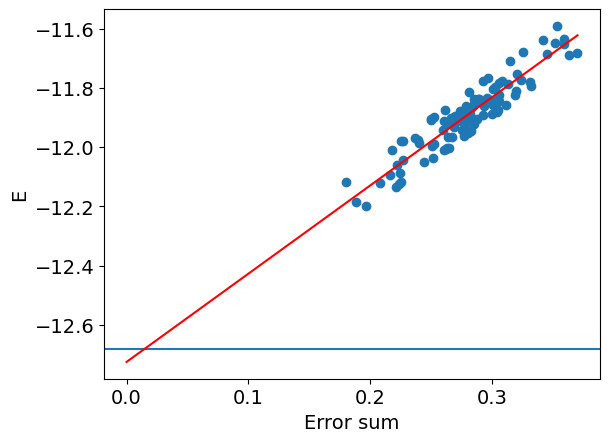

In [24]:
regress_result = linregress(errorsums, energies)
# plt.figure(figsize=(6.4, 4.8))
plt.plot(errorsums, energies, 'o')
plt.axhline(sol_clean.fun)
plt.plot([0, max(errorsums)], 
         regress_result.intercept 
         + regress_result.slope * np.array([0, max(errorsums)]), 
         'r')

plt.xlabel("Error sum")
plt.ylabel("E")

if save:
    plt.savefig(foldername + "/perm_fit_example.png", dpi=400, bbox_inches='tight')

In [25]:
regress_result = linregress(errorsums, energies)
print(regress_result.intercept - sol_clean.fun)

-0.04347569369454973


In [26]:
if save:
    np.savetxt(foldername + '/example_energies.txt', energies)
    np.savetxt(foldername + '/example_errorsums.txt', errorsums)


### Investigate how quantity of permutations affects the quality of the fit

In [27]:
# intercept_points = np.zeros((len(perms_numbers), tests_per_perm_qty))

# nm = make_nm(qs, noise_type, n_qubits)

# for i, qty in enumerate(perms_numbers):
#     for j in tqdm(range(tests_per_perm_qty)):
#         permutations = random_perms(n_qubits, qty, rng)
#         errorsums = np.zeros(qty)
#         energies = np.zeros(qty)

#         for k, perm in enumerate(permutations):
#             circ_perm = permute_circuit(circ, perm)
#             h_perm = h.permute(list(perm))
#             errorsums[k] = error_sum(circ_perm, np.zeros(circ.num_qubits), new_qs)
#             energies[k] = get_energy_estimator(circ_perm, h_perm, nm)(sol_clean.x)
#         regress_result = linregress(errorsums, energies)
#         intercept_points[i, j] = regress_result.intercept

In [28]:
intercept_points = np.zeros((len(perms_numbers), tests_per_perm_qty))

for i, qty in enumerate(perms_numbers):
    for j in tqdm(range(tests_per_perm_qty)):
        permutations = random_perms(n_qubits, qty, rng)
        errorsums = np.zeros(qty)
        energies = np.zeros(qty)

        for k, perm in enumerate(permutations):
            P = permutation_matrix(perm)
            new_qs = P @ qs @ P.T
            nm = make_nm(new_qs, noise_type, n_qubits)
            errorsums[k] = error_sum(circ, np.zeros(circ.num_qubits), new_qs)
            energies[k] = get_energy_estimator(circ, h, nm)(sol_clean.x)
        regress_result = linregress(errorsums, energies)
        intercept_points[i, j] = regress_result.intercept

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [30:11<00:00, 36.23s/it]


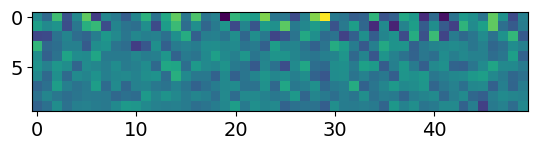

In [29]:
plt.imshow(intercept_points)

In [30]:
mean_q = np.mean(qs) * (n_qubits**2) / (n_qubits * (n_qubits - 1))

In [31]:
sol_clean.fun

-12.681994553042976

In [32]:
typical_energy = ((np.mean(perturbed_energies) - sol_clean.fun)
                  * mean_q * len(perturbed_energies))
print(typical_energy)

0.8964448505578879


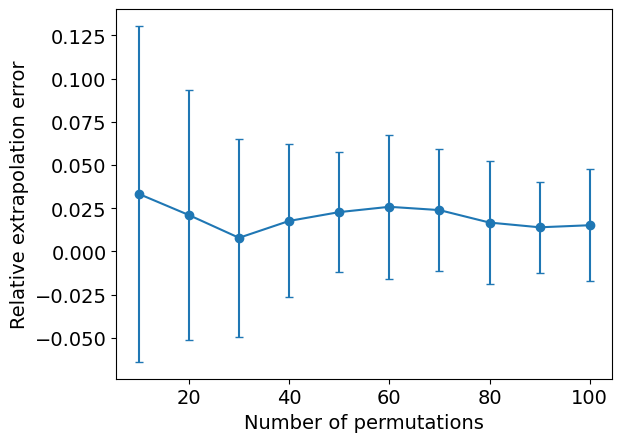

In [33]:
means = np.mean(intercept_points, axis=1)
variances = np.var(intercept_points, axis=1, ddof=1)

plt.errorbar(perms_numbers, (means - sol_clean.fun), 
             yerr = variances**0.5, fmt='o-', capsize=3)
plt.xlabel('Number of permutations')
plt.ylabel('Relative extrapolation error')
# plt.grid()
plt.savefig(foldername + "/ZNE_error.png", dpi=400, bbox_inches='tight')

In [34]:
np.savetxt(foldername + '/means.txt', means)
np.savetxt(foldername + '/variances.txt', variances)

### Compare data from different experiments

In [38]:
foldername_1 = './Tue, 28 Mar 2023 09:37:35'
foldername_2 = './Tue, 28 Mar 2023 10:03:19'

In [39]:
aggreg_eps_1 = np.loadtxt(foldername_1 + "/aggregated_epsilons.txt")
aggreg_eps_2 = np.loadtxt(foldername_2 + "/aggregated_epsilons.txt")

In [40]:
aggreg_eps_2

array([ 6.68237632,  6.72402766,  7.43335718, -6.73585156, -7.20442115,
       -6.89948845])

Text(0, 0.5, '$\\tilde{\\epsilon}$')

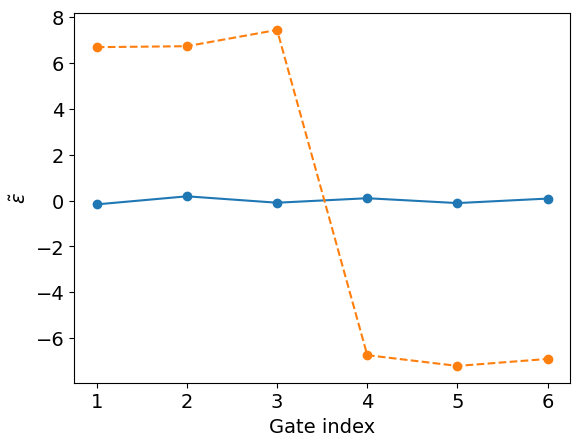

In [41]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(np.arange(len(aggreg_eps_1)) + 1, 
         aggreg_eps_1, 'o-')
plt.plot(np.arange(len(aggreg_eps_2)) + 1, 
         aggreg_eps_2, 'o--')
plt.xlabel("Gate index")
plt.ylabel("$\\tilde{\epsilon}$")
# plt.savefig(foldername_1 + "/aggregate_epsilons_compare_ms", dpi=400, bbox_inches='tight')

In [42]:
errorsums_1 = np.loadtxt(foldername_1 + '/example_errorsums.txt')
energies_1 = np.loadtxt(foldername_1 + '/example_energies.txt')

errorsums_2 = np.loadtxt(foldername_2 + '/example_errorsums.txt')
energies_2 = np.loadtxt(foldername_2 + '/example_energies.txt')

In [43]:
with open(foldername_1 + "/sol.txt", "r") as fp:
    sol_1 = json.load(fp)
    
with open(foldername_2 + "/sol.txt", "r") as fp:
    sol_2 = json.load(fp)

In [44]:
sol_1['fun']

-7.618290708891737

Text(0, 0.5, 'E')

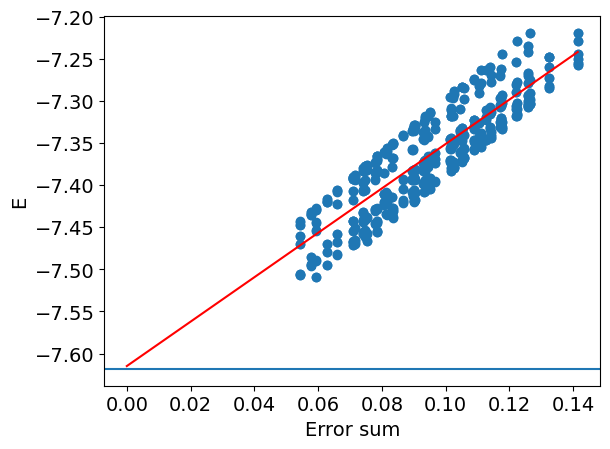

In [45]:
plt.figure(figsize=(6.4, 4.8))
regress_result_1 = linregress(errorsums_1, energies_1)
plt.plot(errorsums_1, energies_1, 'o')
plt.axhline(sol_1['fun'])
plt.plot([0, max(errorsums_1)], 
         regress_result_1.intercept 
         + regress_result_1.slope * np.array([0, max(errorsums_1)]), 
         'r')

plt.xlabel("Error sum")
plt.ylabel("E")

# plt.savefig(foldername_1 + "/perm_fit_example_clean", dpi=400, bbox_inches='tight')

In [46]:
zne_error = regress_result_1.intercept - sol_1['fun']

print(zne_error)
print(zne_error / np.min(energies_1 - sol_1['fun']))
print(zne_error / np.mean(energies_1 - sol_1['fun']))

print(np.min(energies_1 - sol_1['fun']) / zne_error)
print(np.mean(energies_1 - sol_1['fun']) / zne_error)

0.0034016461756669614
0.031135313570339548
0.013422556586675306
32.117871488297155
74.50145533323429


Text(0, 0.5, 'E')

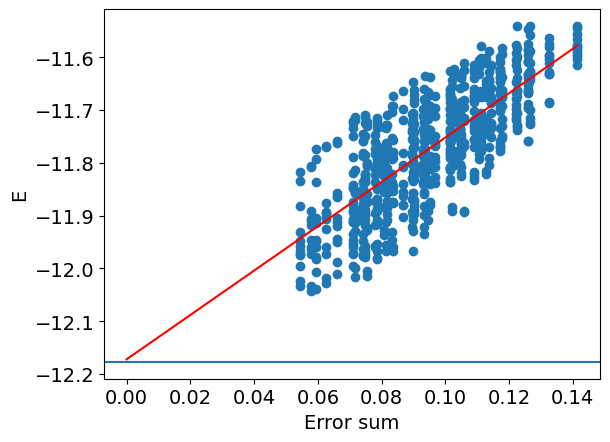

In [47]:
plt.figure(figsize=(6.4, 4.8))
regress_result_2 = linregress(errorsums_2, energies_2)
plt.plot(errorsums_2, energies_2, 'o')
plt.axhline(sol_2['fun'])
plt.plot([0, max(errorsums_2)], 
         regress_result_2.intercept 
         + regress_result_2.slope * np.array([0, max(errorsums_2)]), 
         'r')

plt.xlabel("Error sum")
plt.ylabel("E")

# plt.savefig(foldername_2 + "/perm_fit_example_tilt", dpi=400, bbox_inches='tight')

In [48]:
zne_error = regress_result_2.intercept - sol_2['fun']

print(zne_error)
print(zne_error / np.min(energies_2 - sol_2['fun']))
print(zne_error / np.mean(energies_2 - sol_2['fun']))

print(np.min(energies_2 - sol_2['fun']) / zne_error)
print(np.mean(energies_2 - sol_2['fun']) / zne_error)

0.004888001922150664
0.036605124002095354
0.012124884748451697
27.31857976885307
82.47501075238644


Text(0, 0.5, 'E')

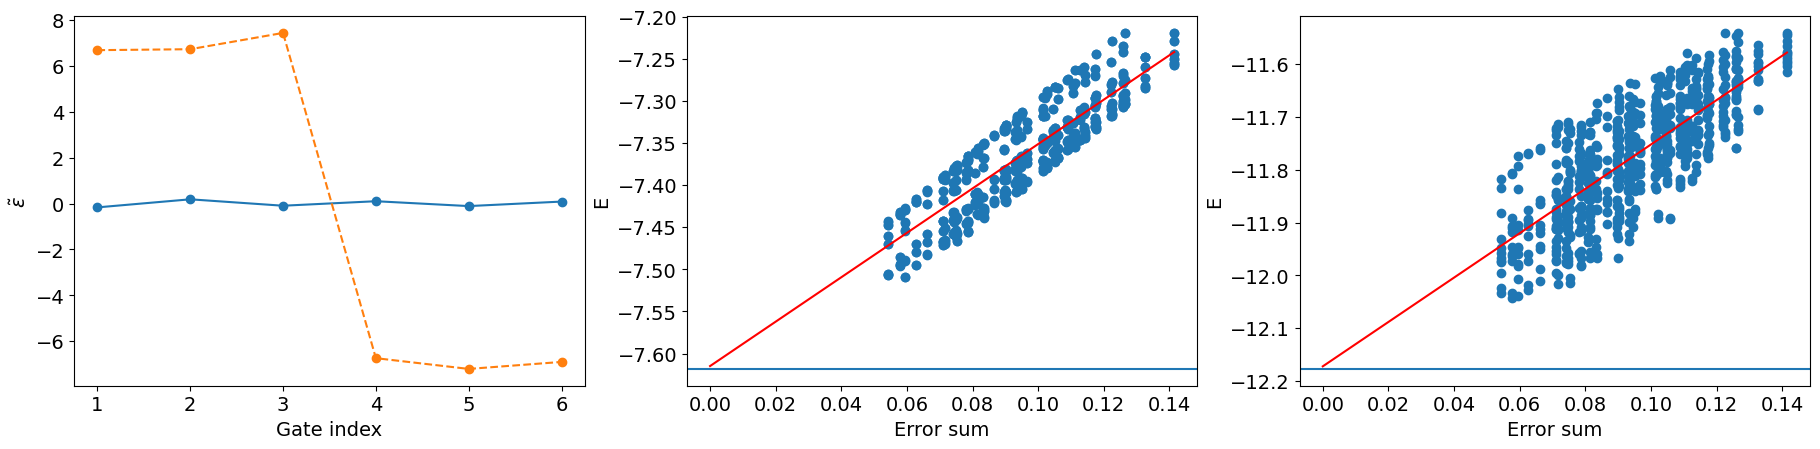

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.4 * 3.5, 4.8))

axs[0].plot(np.arange(len(aggreg_eps_1)) + 1, 
         aggreg_eps_1, 'o-')
axs[0].plot(np.arange(len(aggreg_eps_2)) + 1, 
         aggreg_eps_2, 'o--')
axs[0].set_xlabel("Gate index")
axs[0].set_ylabel("$\\tilde{\epsilon}$")


regress_result = linregress(errorsums_1, energies_1)
axs[1].plot(errorsums_1, energies_1, 'o')
axs[1].axhline(sol_1['fun'])
axs[1].plot([0, max(errorsums_1)], 
         regress_result.intercept 
         + regress_result.slope * np.array([0, max(errorsums_1)]), 
         'r')

axs[1].set_xlabel("Error sum")
axs[1].set_ylabel("E")



regress_result = linregress(errorsums_2, energies_2)
axs[2].plot(errorsums_2, energies_2, 'o')
axs[2].axhline(sol_2['fun'])
axs[2].plot([0, max(errorsums_2)], 
         regress_result.intercept 
         + regress_result.slope * np.array([0, max(errorsums_2)]), 
         'r')

axs[2].set_xlabel("Error sum")
axs[2].set_ylabel("E")

# plt.savefig(foldername_1 + '/epsilons_and_examples with ' + foldername_2[2:], dpi=400, bbox_inches='tight')


In [60]:
with open(foldername_1 + "/inputs.txt", "r") as fp:
    inputs_1 = json.load(fp)
    
with open(foldername_2 + "/inputs.txt", "r") as fp:
    inputs_2 = json.load(fp)

In [61]:
inputs_1

{'h_type': 'ISING',
 'ansatz_type': 'CIRCULAR',
 'noise_type': 'DEPOL',
 'vqe_starting_point': 'SMALL_RANDOM',
 'n_qubits': 6,
 'n_perms_for_example': 720,
 'perms_numbers': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'tests_per_perm_qty': 50,
 'ansatz_depth': 3,
 'global_seed': 0,
 'noise_seed': 0,
 'note': 'All experiments before Mar 28 have a different qs sampling procedure'}

In [62]:
inputs_2

{'h_type': 'ISING',
 'ansatz_type': 'LINEAR',
 'noise_type': 'DEPOL',
 'vqe_starting_point': 'SMALL_RANDOM',
 'n_qubits': 6,
 'n_perms_for_example': 720,
 'perms_numbers': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'tests_per_perm_qty': 50,
 'ansatz_depth': 3,
 'global_seed': 0,
 'noise_seed': 0,
 'note': 'All experiments before Mar 28 have a different qs sampling procedure'}

In [63]:
means_1 = np.loadtxt(foldername_1 + "/means.txt")
means_2 = np.loadtxt(foldername_2 + "/means.txt")

variances_1 = np.loadtxt(foldername_1 + "/variances.txt")
variances_2 = np.loadtxt(foldername_2 + "/variances.txt")

In [ ]:
typ_en_1 = 0.30838229933219136

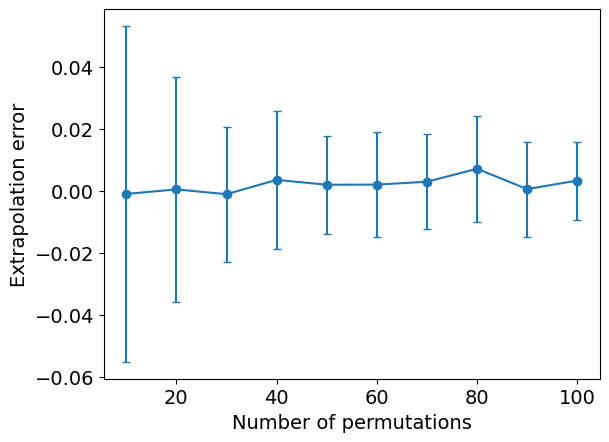

In [49]:
ys = means_1 - sol_1['fun']
plt.errorbar(inputs_1['perms_numbers'], ys, yerr=variances_1**0.5, fmt='o-', capsize=3)

plt.xlabel('Number of permutations')
plt.ylabel('Extrapolation error')
# plt.grid()
plt.savefig(foldername_1 + "/ZNE_absolute_error.png", dpi=400, bbox_inches='tight')

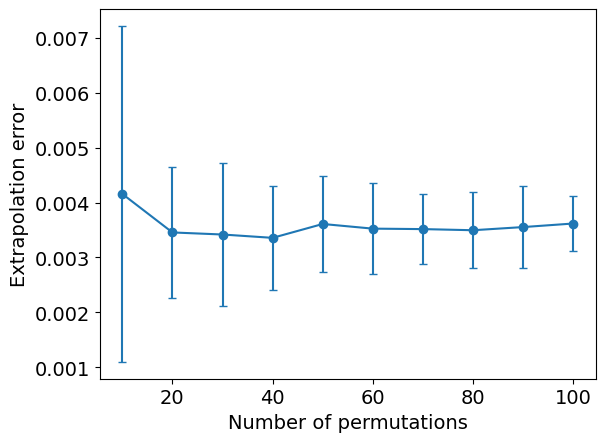

In [64]:
ys = means_2 - sol_2['fun']
plt.errorbar(inputs_2['perms_numbers'], ys, yerr=variances_2**0.5, fmt='o-', capsize=3)

plt.xlabel('Number of permutations')
plt.ylabel('Extrapolation error')
# plt.grid()
plt.savefig(foldername_2 + "/ZNE_absolute_error.png", dpi=400, bbox_inches='tight')